# Image Classification with CIFAR-10 dataset

## Get the Data
Run the following cell to download the [CIFAR-10 dataset for python](https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz).

# 1st Way 

## Import Libraries

In [40]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [3]:
cifar10_dataset_folder_path = 'cifar-10-batches-py'

In [4]:
def load_label_names():
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

### Reshaping the data into the form which tensorflow understands?

The row vector (3072) has the exact same number of elements if you calculate 32\*32\*3==3072. In order to reshape the row vector, (3072), there are two steps required. The **first** step is involved with using **reshape** function in numpy, and the **second** step is involved with using **transpose** function in numpy as well.

By definition from the official web site, **reshape** function gives a new shape to an array without changing its data. Here, the phrase **without changing its data** is an important part. **reshape** operations should be delivered in three more detailed step. The following direction is described in a logical concept. 

1. divide the row vector (3072) into 3 pieces. Each piece corresponds to each channels.
  - this results in (3 x 1024) dimension of tensor
2. divide the resulting tensor from the previous step with 32. 32 here means width of an image.
  - this results in (3 x 32 x 32)

In order to implement the directions written in logical sense in numpy, **reshape** function should be called in the following arguments, (10000, 3, 32, 32). As you noticed, reshape function doesn't automatically divide further when the third value (32, width) is provided. We need to explicitly specify the value for the last value (32, height)


This is not the end of story. Now, the image data is represented as (num_channel, width, height) form. However, **this is not the shape tensorflow and matplotlib are expecting**. They are expecting different shape of (width, height, num_channel) instead. We need to swap the order of each axes, and that is where **transpose** function comes in.

The **transpose** function can take a list of axes, and each value specifies where it wants to move around. For example, calling transpose with argument (1, 2, 0) in an numpy array of (num_channel, width, height) will return a new numpy array of (width, height, num_channel).

In [6]:
def load_cfar10_batch(cifar10_dataset_folder_path, batch_id):
    with open(cifar10_dataset_folder_path + '/data_batch_' + str(batch_id), mode='rb') as file:
        # note the encoding type is 'latin1'
        batch = pickle.load(file, encoding='latin1')
        
    features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    labels = batch['labels']
        
    return features, labels

## Explore the Data
The display_stats defined below answers some of questions like in a given batch of data..
- "What are all possible labels?"
- "What is the range of values for the image data?"
- "Are the labels in order or random?"


In [8]:
def display_stats(cifar10_dataset_folder_path, batch_id, sample_id):
    features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_id)
    
    if not (0 <= sample_id < len(features)):
        print('{} samples in batch {}.  {} is out of range.'.format(len(features), batch_id, sample_id))
        return None

    print('\nStats of batch #{}:'.format(batch_id))
    print('# of Samples: {}\n'.format(len(features)))
    
    label_names = load_label_names()
    label_counts = dict(zip(*np.unique(labels, return_counts=True)))
    for key, value in label_counts.items():
        print('Label Counts of [{}]({}) : {}'.format(key, label_names[key].upper(), value))
    
    sample_image = features[sample_id]
    sample_label = labels[sample_id]
    
    print('\nExample of Image {}:'.format(sample_id))
    print('Image - Min Value: {} Max Value: {}'.format(sample_image.min(), sample_image.max()))
    print('Image - Shape: {}'.format(sample_image.shape))
    print('Label - Label Id: {} Name: {}'.format(sample_label, label_names[sample_label]))
    
    plt.imshow(sample_image)


Stats of batch #3:
# of Samples: 10000

Label Counts of [0](AIRPLANE) : 994
Label Counts of [1](AUTOMOBILE) : 1042
Label Counts of [2](BIRD) : 965
Label Counts of [3](CAT) : 997
Label Counts of [4](DEER) : 990
Label Counts of [5](DOG) : 1029
Label Counts of [6](FROG) : 978
Label Counts of [7](HORSE) : 1015
Label Counts of [8](SHIP) : 961
Label Counts of [9](TRUCK) : 1029

Example of Image 7000:
Image - Min Value: 24 Max Value: 252
Image - Shape: (32, 32, 3)
Label - Label Id: 0 Name: airplane


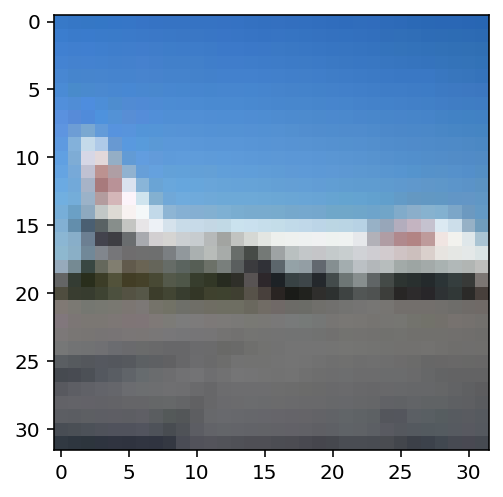

In [9]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np

# Explore the dataset
batch_id = 3
sample_id = 7000
display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

## Implement Preprocess Functions
### Normalize
**Min-Max Normalization**
- this simply makes all x values to range between 0 and 1.
- y = (x-min) / (max-min)
`normalize` function takes an image data, `x`, and returns it as a normalized Numpy array. The values in the original data is going to be transformed in range of 0 to 1, inclusive without change the shape of the array. A simply answer to why normalization should be performed is somewhat related to activation function.

For example, sigmoid activation function takes an input value and outputs a new value ranging from 0 to 1. When the input value is somewhat large, the output value reaches the max value 1. Similarily, when the input value is somewhat small, the output value reaches the max value 0. 

For another example, ReLU activation function takes an input value and outputs a new value ranging from 0 to infinity. When the input value is somewhat large, the output value increases linearly. However, when the input value is somewhat small, the output value reaches the max value 0.

Now, when we think about the image data, all values originally ranges from 0 to 255. This sounds like when it is passed into sigmoid function, the output is almost always 1, and when it is passed into ReLu function, the output could be very huge. When backpropagation process is performed to optimize the networks, this could lead to an exploding gradient which leads to an aweful learning steps. In order to avoid this issue, ideally, it is better let all the values be around 0 and 1.

In [11]:
def normalize(x):
    """
        argument
            - x: input image data in numpy array [32, 32, 3]
        return
            - normalized x 
    """
    min_val = np.min(x)
    max_val = np.max(x)
    x = (x-min_val) / (max_val-min_val)
    return x

### One-hot encode

Since the output of our model is going to show the probabilities of where an image should be categorized as a prediction. There should be a vector having the same number of elements as the number of image classes. For instance, CIFAR-10 provides 10 different classes of image, so we need a vector in size of 10 as well. Each element represents the predicting probability of each classes.

In [12]:
def one_hot_encode(x):
    """
        argument
            - x: a list of labels
        return
            - one hot encoding matrix (number of labels, number of class)
    """
    encoded = np.zeros((len(x), 10))
    
    for idx, val in enumerate(x):
        encoded[idx][val] = 1
    
    return encoded

## Preprocess all the data and save it

The code cell below uses the previously implemented functions, normalize and one_hot_encode, to preprocess the given dataset.
Running the code cell below will preprocess all the CIFAR-10 data and save it to file. The code below also uses 10% of the training data for validation.

In [13]:
def _preprocess_and_save(normalize, one_hot_encode, features, labels, filename):
    features = normalize(features)
    labels = one_hot_encode(labels)

    pickle.dump((features, labels), open(filename, 'wb'))


def preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode):
    n_batches = 5
    valid_features = []
    valid_labels = []

    for batch_i in range(1, n_batches + 1):
        features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_i)
        
        # find index to be the point as validation data in the whole dataset of the batch (10%)
        index_of_validation = int(len(features) * 0.1)

        # preprocess the 90% of the whole dataset of the batch
        # - normalize the features
        # - one_hot_encode the lables
        # - save in a new file named, "preprocess_batch_" + batch_number
        # - each file for each batch
        _preprocess_and_save(normalize, one_hot_encode,
                             features[:-index_of_validation], labels[:-index_of_validation], 
                             'preprocess_batch_' + str(batch_i) + '.p')

        # unlike the training dataset, validation dataset will be added through all batch dataset
        # - take 10% of the whold dataset of the batch
        # - add them into a list of
        #   - valid_features
        #   - valid_labels
        valid_features.extend(features[-index_of_validation:])
        valid_labels.extend(labels[-index_of_validation:])

    # preprocess the all stacked validation dataset
    _preprocess_and_save(normalize, one_hot_encode,
                         np.array(valid_features), np.array(valid_labels),
                         'preprocess_validation.p')

    # load the test dataset
    with open(cifar10_dataset_folder_path + '/test_batch', mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')

    # preprocess the testing data
    test_features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    test_labels = batch['labels']

    # Preprocess and Save all testing data
    _preprocess_and_save(normalize, one_hot_encode,
                         np.array(test_features), np.array(test_labels),
                         'preprocess_training.p')

In [14]:
preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)

In [15]:
import pickle

valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

## TensorFlow 

### Prepare Input for the Model


In [20]:
# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

# Inputs
x = tf.placeholder(tf.float32, shape=(None, 32, 32, 3), name='input_x')
y =  tf.placeholder(tf.float32, shape=(None, 10), name='output_y')
keep_prob = tf.placeholder(tf.float32, name='keep_prob')

### Create Convolutional Model

The entire model consists of 14 layers in total. In addition to layers below lists what techniques are applied to build the model.

1. Convolution with 64 different filters in size of (3x3)
2. Max Pooling by 2
  - ReLU activation function 
  - Batch Normalization
3. Convolution with 128 different filters in size of (3x3)
4. Max Pooling by 2
  - ReLU activation function 
  - Batch Normalization
5. Convolution with 256 different filters in size of (3x3)
6. Max Pooling by 2
  - ReLU activation function 
  - Batch Normalization
7. Convolution with 512 different filters in size of (3x3)
8. Max Pooling by 2
  - ReLU activation function 
  - Batch Normalization
9. Flattening the 3-D output of the last convolutional operations.
10. Fully Connected Layer with 128 units
  - Dropout 
  - Batch Normalization
11. Fully Connected Layer with 256 units
  - Dropout 
  - Batch Normalization
12. Fully Connected Layer with 512 units
  - Dropout 
  - Batch Normalization
13. Fully Connected Layer with 1024 units
  - Dropout 
  - Batch Normalization
14. Fully Connected Layer with 10 units (number of image classes)

In [21]:
#import tensorflow as tf

def conv_net(x, keep_prob):
    conv1_filter = tf.Variable(tf.truncated_normal(shape=[3, 3, 3, 64], mean=0, stddev=0.08))
    conv2_filter = tf.Variable(tf.truncated_normal(shape=[3, 3, 64, 128], mean=0, stddev=0.08))
    conv3_filter = tf.Variable(tf.truncated_normal(shape=[5, 5, 128, 256], mean=0, stddev=0.08))
    conv4_filter = tf.Variable(tf.truncated_normal(shape=[5, 5, 256, 512], mean=0, stddev=0.08))

    # 1, 2
    conv1 = tf.nn.conv2d(x, conv1_filter, strides=[1,1,1,1], padding='SAME')
    conv1 = tf.nn.relu(conv1)
    conv1_pool = tf.nn.max_pool(conv1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    conv1_bn = tf.layers.batch_normalization(conv1_pool)

    # 3, 4
    conv2 = tf.nn.conv2d(conv1_bn, conv2_filter, strides=[1,1,1,1], padding='SAME')
    conv2 = tf.nn.relu(conv2)
    conv2_pool = tf.nn.max_pool(conv2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')    
    conv2_bn = tf.layers.batch_normalization(conv2_pool)
  
    # 5, 6
    conv3 = tf.nn.conv2d(conv2_bn, conv3_filter, strides=[1,1,1,1], padding='SAME')
    conv3 = tf.nn.relu(conv3)
    conv3_pool = tf.nn.max_pool(conv3, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')  
    conv3_bn = tf.layers.batch_normalization(conv3_pool)
    
    # 7, 8
    conv4 = tf.nn.conv2d(conv3_bn, conv4_filter, strides=[1,1,1,1], padding='SAME')
    conv4 = tf.nn.relu(conv4)
    conv4_pool = tf.nn.max_pool(conv4, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    conv4_bn = tf.layers.batch_normalization(conv4_pool)
    
    # 9
    flat = tf.contrib.layers.flatten(conv4_bn)  

    # 10
    full1 = tf.contrib.layers.fully_connected(inputs=flat, num_outputs=128, activation_fn=tf.nn.relu)
    full1 = tf.nn.dropout(full1, keep_prob)
    full1 = tf.layers.batch_normalization(full1)
    
    # 11
    full2 = tf.contrib.layers.fully_connected(inputs=full1, num_outputs=256, activation_fn=tf.nn.relu)
    full2 = tf.nn.dropout(full2, keep_prob)
    full2 = tf.layers.batch_normalization(full2)
    
    # 12
    full3 = tf.contrib.layers.fully_connected(inputs=full2, num_outputs=512, activation_fn=tf.nn.relu)
    full3 = tf.nn.dropout(full3, keep_prob)
    full3 = tf.layers.batch_normalization(full3)    
    
    # 13
    full4 = tf.contrib.layers.fully_connected(inputs=full3, num_outputs=1024, activation_fn=tf.nn.relu)
    full4 = tf.nn.dropout(full4, keep_prob)
    full4 = tf.layers.batch_normalization(full4)        
    
    # 14
    out = tf.contrib.layers.fully_connected(inputs=full3, num_outputs=10, activation_fn=None)
    return out

### Hyperparameters

* `epochs`: number of iterations until the network stops learning or start overfitting
* `batch_size`: highest number that your machine has memory for.  Most people set them to common sizes of memory:
* `keep_probability`: probability of keeping a node using dropout
* `learning_rate`: number how fast the model learns

In [29]:
epochs = 20
batch_size = 64
keep_probability = 0.7
learning_rate = 0.001

### Cost Function & Optimizer

## Train the Neural Network

We have defined cost, optimizer and accuracy, and what they really are is..
- **cost**:  
   - tf.reduce_mean returns => The reduced **Tensor**
- **optimizer**:  
   - tf.train.AdamOptimizer returns => An **Operation** that applies the specified gradients.
- **accuracy**: 
   - tf.reduce_mean returns => The reduced **Tensor**

### Single Optimization


# 2nd Way

In [44]:
from tensorflow.keras import datasets, layers, models #Importing models
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


### Show Stats


In [45]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

170500096/170498071 [==============================] - 24s 0us/step


### Fully Train the Model

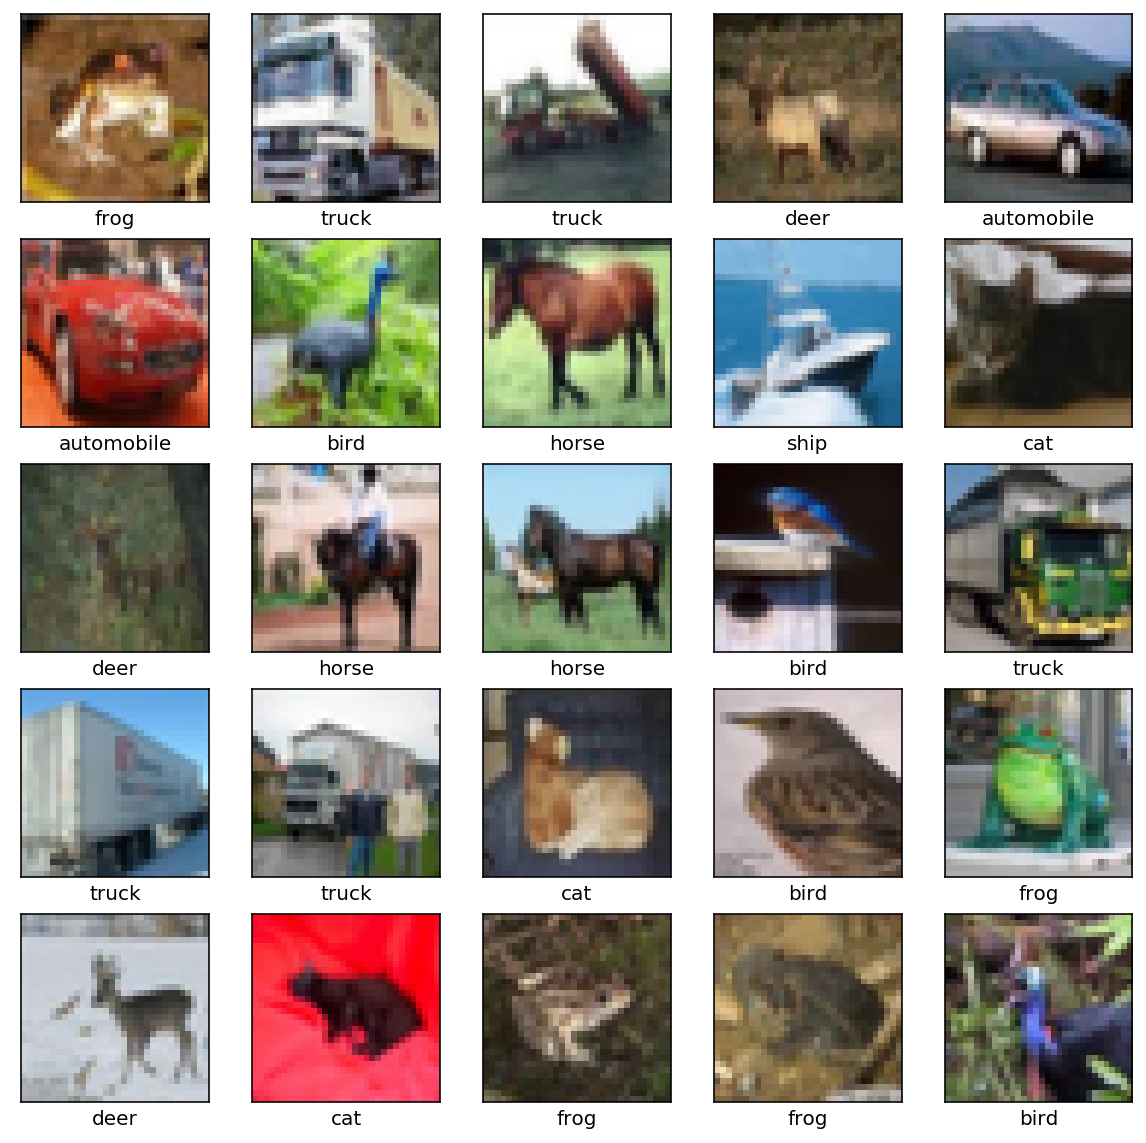

In [47]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

## Create the convolutional base

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

### Model Structure

In [48]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          36928     
Total params: 56,320
Trainable params: 56,320
Non-trainable params: 0
_________________________________________________________________


### Add Dense layers on top

In [49]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

In [50]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                6

### Compile and train the model

In [51]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=20, 
                    validation_data=(test_images, test_labels))

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 29s 583us/sample - loss: 1.4738 - accuracy: 0.4643 - val_loss: 1.2315 - val_accuracy: 0.5579
Epoch 2/20
50000/50000 [==============================] - 30s 604us/sample - loss: 1.0982 - accuracy: 0.6110 - val_loss: 1.0451 - val_accuracy: 0.6312
Epoch 3/20
50000/50000 [==============================] - 33s 659us/sample - loss: 0.9470 - accuracy: 0.6655 - val_loss: 0.9878 - val_accuracy: 0.6542
Epoch 4/20
50000/50000 [==============================] - 31s 623us/sample - loss: 0.8503 - accuracy: 0.7021 - val_loss: 0.8837 - val_accuracy: 0.6919
Epoch 5/20
50000/50000 [==============================] - 32s 645us/sample - loss: 0.7802 - accuracy: 0.7277 - val_loss: 0.8959 - val_accuracy: 0.6880
Epoch 6/20
50000/50000 [==============================] - 33s 660us/sample - loss: 0.7165 - accuracy: 0.7485 - val_loss: 0.8493 - val_accuracy: 0.7094
Epoch 7/20
50000/50000 [====================

### Evaluate the model

10000/10000 - 3s - loss: 1.2646 - accuracy: 0.7066


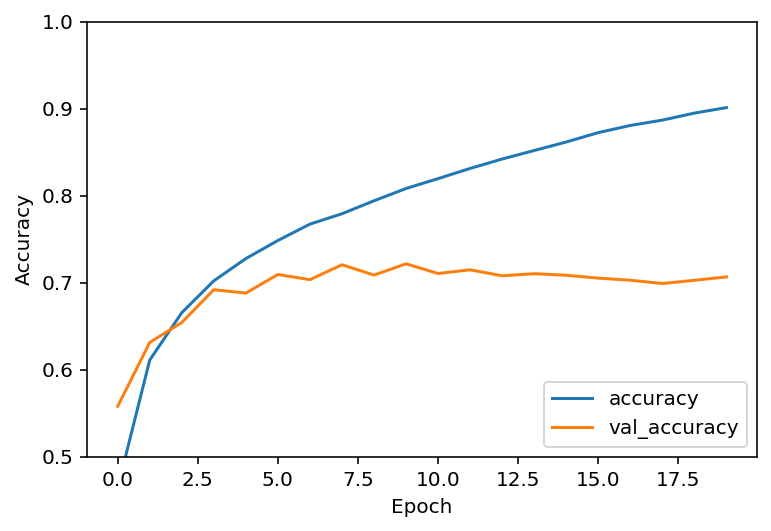

In [52]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

In [53]:
print(test_acc)

0.7066


That means 70.66% is the test accuracy for this simple model.

# 3rd Way with all the parameters

In [55]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import KFold
from tensorflow.keras.layers import Dropout

In [56]:
# Model configuration and hyperparameters
verbosity = 1

loss_function = sparse_categorical_crossentropy
no_classes = 10
no_epochs = 20
#optimizer = Adam(learning_rate=0.001)
optimizer = SGD(learning_rate=0.01, momentum=0.95)
batch_size = 256
validation_split = 0.2
num_folds = 10

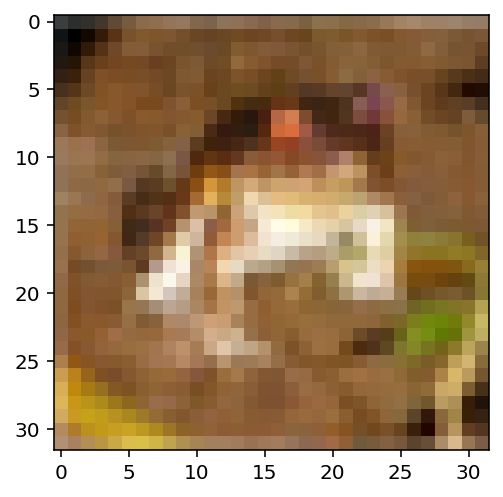

In [57]:
# Load cifar10 data and show sample of the dataset
(input_train, target_train), (input_test, target_test) = cifar10.load_data()
plt.imshow(input_train[0], cmap='gray_r')

### Data preprocessing 

In [58]:
# Parse numbers as floats
input_train = input_train.astype('float32')
input_test = input_test.astype('float32')

# Normalize data
input_train = input_train / 255
input_test = input_test / 255

*Sequential Model Building with Activation for each layer

*Compile with categorical CE loss and metric accuracy

*Train Model with cross validation, with total time taken shown for 20 epochs

In [59]:
# 1 2 3 4 5
# 2 2 2 2 2
# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []

# Merge inputs and targets
inputs = np.concatenate((input_train, input_test), axis=0)
targets = np.concatenate((target_train, target_test), axis=0)

# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(inputs, targets):

  # Define the model architecture (Input layer, hidden layers and output layers)
  model = Sequential()

  model.add(Flatten())
  model.add(Dense(64, activation='sigmoid', kernel_regularizer=keras.regularizers.l2(0.0001)))
  model.add(Dropout(0.25))

  model.add(Dense(64, activation='sigmoid', kernel_regularizer=keras.regularizers.l2(0.0001)))
  model.add(Dropout(0.25))

  model.add(Dense(32, activation='sigmoid', kernel_regularizer=keras.regularizers.l2(0.0001)))
  model.add(Dropout(0.25))

  model.add(Dense(no_classes, activation='softmax'))

  # Compile the model
  model.compile(loss=loss_function,
                optimizer=optimizer,
                metrics=['accuracy'])


  # Generate a output summary
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  # Fit data to model
  history = model.fit(inputs[train], targets[train],
              batch_size=batch_size,
              epochs=no_epochs,
              verbose=verbosity,
              validation_split=validation_split)

  # Generate generalization metrics
  scores = model.evaluate(inputs[test], targets[test], verbose=0)

  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  # Increment fold number
  fold_no = fold_no + 1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')

print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')


------------------------------------------------------------------------
Training for fold 1 ...
Train on 43200 samples, validate on 10800 samples
Epoch 1/20
43200/43200 [==============================] - 3s 71us/sample - loss: 2.3788 - accuracy: 0.1011 - val_loss: 2.3233 - val_accuracy: 0.1009
Epoch 2/20
43200/43200 [==============================] - 2s 53us/sample - loss: 2.3349 - accuracy: 0.1054 - val_loss: 2.3196 - val_accuracy: 0.1597
Epoch 3/20
43200/43200 [==============================] - 2s 53us/sample - loss: 2.3244 - accuracy: 0.1111 - val_loss: 2.3118 - val_accuracy: 0.1602
Epoch 4/20
43200/43200 [==============================] - 2s 51us/sample - loss: 2.3107 - accuracy: 0.1255 - val_loss: 2.2852 - val_accuracy: 0.1905
Epoch 5/20
43200/43200 [==============================] - 2s 55us/sample - loss: 2.2603 - accuracy: 0.1475 - val_loss: 2.1841 - val_accuracy: 0.1851
Epoch 6/20
43200/43200 [==============================] - 2s 52us/sample - loss: 2.1741 - accuracy: 0.1684 -

Epoch 12/20
43200/43200 [==============================] - 2s 53us/sample - loss: 2.0899 - accuracy: 0.1906 - val_loss: 2.0610 - val_accuracy: 0.2112
Epoch 13/20
43200/43200 [==============================] - 2s 51us/sample - loss: 2.0846 - accuracy: 0.1917 - val_loss: 2.0576 - val_accuracy: 0.2172
Epoch 14/20
43200/43200 [==============================] - 2s 52us/sample - loss: 2.0782 - accuracy: 0.1991 - val_loss: 2.0493 - val_accuracy: 0.2158
Epoch 15/20
43200/43200 [==============================] - 2s 51us/sample - loss: 2.0737 - accuracy: 0.1985 - val_loss: 2.0412 - val_accuracy: 0.2171
Epoch 16/20
43200/43200 [==============================] - 2s 53us/sample - loss: 2.0664 - accuracy: 0.2056 - val_loss: 2.0323 - val_accuracy: 0.2284
Epoch 17/20
43200/43200 [==============================] - 2s 53us/sample - loss: 2.0576 - accuracy: 0.2118 - val_loss: 2.0189 - val_accuracy: 0.2469
Epoch 18/20
43200/43200 [==============================] - 2s 52us/sample - loss: 2.0443 - accuracy:

43200/43200 [==============================] - 3s 58us/sample - loss: 2.3265 - accuracy: 0.1106 - val_loss: 2.3073 - val_accuracy: 0.1364
Epoch 3/20
43200/43200 [==============================] - 2s 56us/sample - loss: 2.3009 - accuracy: 0.1297 - val_loss: 2.2593 - val_accuracy: 0.1880
Epoch 4/20
43200/43200 [==============================] - 3s 58us/sample - loss: 2.2291 - accuracy: 0.1531 - val_loss: 2.1535 - val_accuracy: 0.2133
Epoch 5/20
43200/43200 [==============================] - 2s 57us/sample - loss: 2.1578 - accuracy: 0.1689 - val_loss: 2.1003 - val_accuracy: 0.2121
Epoch 6/20
43200/43200 [==============================] - 3s 62us/sample - loss: 2.1246 - accuracy: 0.1819 - val_loss: 2.0810 - val_accuracy: 0.2098
Epoch 7/20
43200/43200 [==============================] - 2s 57us/sample - loss: 2.1104 - accuracy: 0.1864 - val_loss: 2.0703 - val_accuracy: 0.2129
Epoch 8/20
43200/43200 [==============================] - 3s 60us/sample - loss: 2.0949 - accuracy: 0.2011 - val_loss

Epoch 14/20
43200/43200 [==============================] - 2s 56us/sample - loss: 2.0587 - accuracy: 0.2237 - val_loss: 2.0119 - val_accuracy: 0.2519
Epoch 15/20
43200/43200 [==============================] - 2s 56us/sample - loss: 2.0401 - accuracy: 0.2318 - val_loss: 1.9791 - val_accuracy: 0.2639
Epoch 16/20
43200/43200 [==============================] - 2s 58us/sample - loss: 2.0201 - accuracy: 0.2410 - val_loss: 1.9598 - val_accuracy: 0.2743
Epoch 17/20
43200/43200 [==============================] - 2s 56us/sample - loss: 2.0052 - accuracy: 0.2492 - val_loss: 1.9556 - val_accuracy: 0.2742
Epoch 18/20
43200/43200 [==============================] - 2s 55us/sample - loss: 1.9944 - accuracy: 0.2546 - val_loss: 1.9388 - val_accuracy: 0.2812
Epoch 19/20
43200/43200 [==============================] - 2s 55us/sample - loss: 1.9902 - accuracy: 0.2582 - val_loss: 1.9337 - val_accuracy: 0.2889
Epoch 20/20
43200/43200 [==============================] - 2s 54us/sample - loss: 1.9804 - accuracy: